In [ ]:
!pip install basemap

In [ ]:
# Data manipulation and processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from mpl_toolkits.basemap import Basemap

# TensorFlow/Keras for deep learning
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.utils import Sequence

# Date and time handling
import datetime as dt


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessandrolobello/the-ultimate-earthquake-dataset-from-1990-2023")

print("Path to dataset files:", path)

100%|██████████| 116M/116M [00:01<00:00, 80.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessandrolobello/the-ultimate-earthquake-dataset-from-1990-2023/versions/4


In [ ]:
# Load the dataset (assumed to have columns ['place', 'longitude', 'latitude', 'magnitude', 'depth', 'date'])
df = pd.read_csv(path+'/Eartquakes-1990-2023.csv')


In [ ]:
def load_and_preprocess_data(file_path):
    # Load data efficiently with date parsing
    df = pd.read_csv(file_path, parse_dates=['date'])
    df['date'] = pd.to_datetime(df['date'], utc=True, errors='coerce')

    # Feature scaling
    scaler = MinMaxScaler()
    df[['magnitudo', 'depth']] = scaler.fit_transform(df[['magnitudo', 'depth']])

    # Extract useful features from the date
    df['day_of_year'] = df['date'].dt.dayofyear
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek
    df['hour'] = df['date'].dt.hour
    df['minute'] = df['date'].dt.minute
    df['second'] = df['date'].dt.second
    df_filtered = df[(df['latitude'] >= 6) & (df['latitude'] <= 37) & (df['longitude'] >= 68) & (df['longitude'] <= 98)]
    return df_filtered, scaler

# Optional: For extremely large datasets, load in chunks using dask
def load_large_data_dask(file_path):
    df = dd.read_csv(file_path, parse_dates=['date'], infer_datetime_format=True)
    return df



Model Performance:
MAE: 0.0043
MSE: 0.0033
RMSE: 0.0572
R² Score: 0.9964


<ipython-input-6-07206fa8998f>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette="viridis")


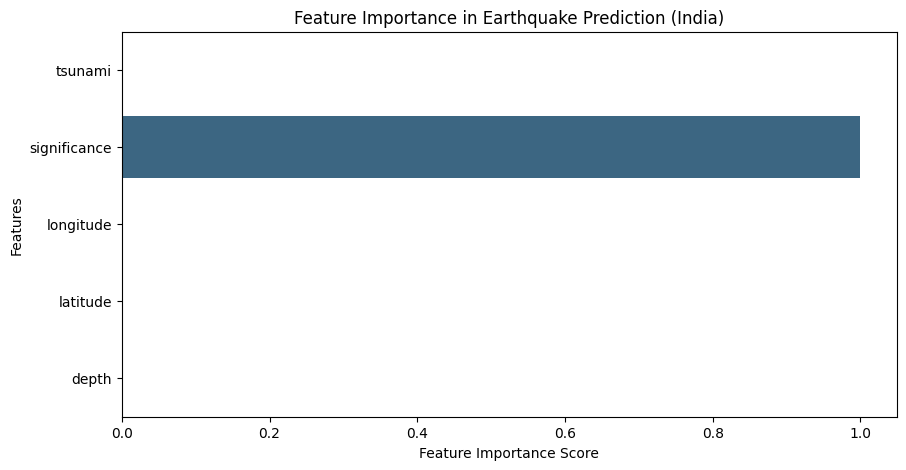

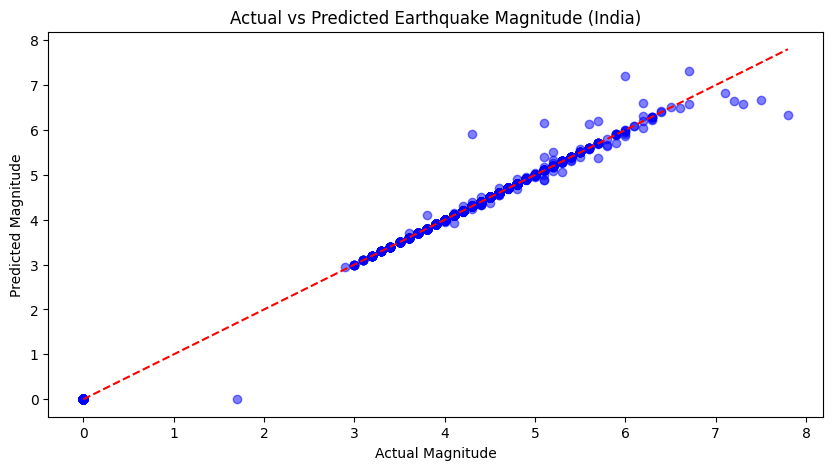

In [ ]:
# Drop non-numeric, unnecessary columns
df = df.drop(columns=['time', 'place', 'state', 'date', 'data_type', 'status'], errors='ignore')

# Fill missing values in numeric columns only
df.fillna(df.select_dtypes(include=[float, int]).mean(), inplace=True)

# Filter for Indian region (latitude: 6°N–38°N, longitude: 68°E–97°E)
df = df[(df['latitude'].between(6, 38)) & (df['longitude'].between(68, 97))]

# Define features (X) and target variable (y)
X = df.drop(columns=['magnitudo'])  # Features
y = df['magnitudo']  # Target variable

# Split data into training/testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Feature Importance Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
importances = model.feature_importances_
feature_names = X.columns
sns.barplot(x=importances, y=feature_names, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Earthquake Prediction (India)")
plt.show()

# Performance Visualization
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual Magnitude")
plt.ylabel("Predicted Magnitude")
plt.title("Actual vs Predicted Earthquake Magnitude (India)")
plt.show()


MAE: 0.0241, R²: 0.9598


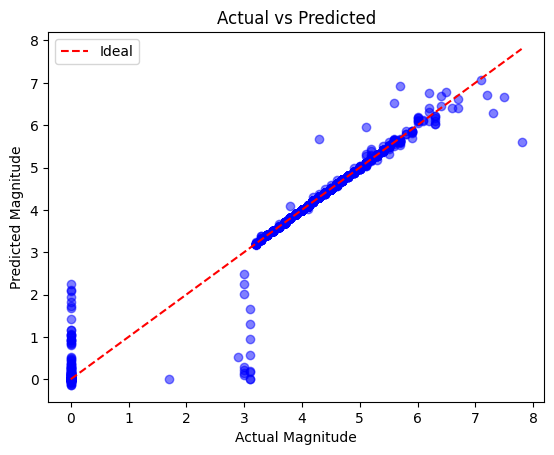

In [ ]:
import xgboost as xgb
# Filter for Indian subcontinent (latitude: 5°N–40°N, longitude: 60°E–100°E)
df = df[(df['latitude'].between(5, 40)) & (df['longitude'].between(60, 100))]

# Drop non-numeric & irrelevant columns
df.drop(columns=['time', 'place', 'state', 'date', 'data_type'], inplace=True, errors='ignore')

# Convert only numeric columns
df = df.apply(pd.to_numeric, errors='coerce')

# Handle missing values
df.fillna(df.mean(), inplace=True)

# Define features & target
X, y = df.drop(columns=['magnitudo']), df['magnitudo']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Predictions & Evaluation
y_pred = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}, R²: {r2_score(y_test, y_pred):.4f}")

# Visualization: Actual vs Predicted
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Ideal")
plt.xlabel("Actual Magnitude"), plt.ylabel("Predicted Magnitude"), plt.title("Actual vs Predicted"), plt.legend()
plt.show()

In [ ]:
class TimeSeriesGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, targets, window_size, batch_size):
        self.data = data  # The entire dataset (features)
        self.targets = targets  # The target dataset (values to predict)
        self.window_size = window_size  # Time steps to look back
        self.batch_size = batch_size  # Batch size for training

    def __len__(self):
        # Ensure that we don't try to create batches that are too large
        return (len(self.data) - self.window_size) // self.batch_size

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        X, y = [], []

        for i in range(start_idx, min(start_idx + self.batch_size, len(self.data) - self.window_size)):
            # Prevent index out of bounds by ensuring that we don't access data past the available indices
            X.append(self.data[i:i + self.window_size])  # NumPy slicing
            y.append(self.targets[i + self.window_size])

        return np.array(X), np.array(y)

    def on_epoch_end(self):
        """Optionally shuffle the data at the end of each epoch."""
        indices = np.arange(len(self.data) - self.window_size)
        np.random.shuffle(indices)
        self.data = self.data[indices]
        self.targets = self.targets[indices]


In [ ]:
class TimeSeriesTransformer(tf.keras.Model):
    def __init__(self, num_heads, ff_dim, num_transformer_blocks, output_dim, input_shape):
        super(TimeSeriesTransformer, self).__init__()

        self.input_projection = layers.Dense(ff_dim)  # Project input features to a higher dimension

        self.positional_encoding = layers.Embedding(input_dim=input_shape[0], output_dim=ff_dim)

        self.transformer_blocks = []
        for _ in range(num_transformer_blocks):
            self.transformer_blocks.append(layers.MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim))
            self.transformer_blocks.append(layers.LayerNormalization())
            self.transformer_blocks.append(layers.Dense(ff_dim, activation='relu'))

        self.flatten = layers.Flatten()
        self.output_layer = layers.Dense(output_dim)

    def call(self, inputs):
        # Apply a dense layer to the input to project it to a higher dimension
        x = self.input_projection(inputs)

        # Apply positional encoding
        seq_length = inputs.shape[1]
        position_indices = tf.range(seq_length)
        position_encoding = self.positional_encoding(position_indices)
        x += position_encoding

        # Pass through transformer blocks
        for block in self.transformer_blocks:
            if isinstance(block, layers.MultiHeadAttention):
                x = block(x, x)
            else:
                x = block(x)

        x = self.flatten(x)
        return self.output_layer(x)

# Model example usage:
num_heads = 8
ff_dim = 64
num_transformer_blocks = 3
input_shape = (30, 4)  # Sequence length of 30, 4 features (magnitude, depth, latitude, longitude)
output_dim = 2  # Predicting magnitude and depth
model = TimeSeriesTransformer(num_heads, ff_dim, num_transformer_blocks, output_dim, input_shape)


In [ ]:
def train_model(df):
    window_size = 30
    batch_size = 32
    target_columns = ['magnitudo', 'depth']

    # Split the dataset into train and test sets
    train_size = int(0.8 * len(df))  # 80% training, 20% testing
    df_train = df[:train_size]
    df_test = df[train_size:]

    # Create generators for both training and validation
    train_generator = TimeSeriesGenerator(
        df_train[['magnitudo', 'depth', 'latitude', 'longitude']].values,
        df_train[target_columns].values,
        window_size,
        batch_size
    )

    test_generator = TimeSeriesGenerator(
        df_test[['magnitudo', 'depth', 'latitude', 'longitude']].values,
        df_test[target_columns].values,
        window_size,
        batch_size
    )

    # Define model parameters
    num_heads = 8
    ff_dim = 64
    num_transformer_blocks = 3
    input_shape = (window_size, 4)  # Sequence length of 30, 4 features (magnitude, depth, lat, long)
    output_dim = 2  # Predicting magnitude and depth

    # Build the model
    model = TimeSeriesTransformer(num_heads=num_heads, ff_dim=ff_dim,
                                  num_transformer_blocks=num_transformer_blocks,
                                  output_dim=output_dim, input_shape=input_shape)

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the model using the generator
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=10,
        steps_per_epoch=len(train_generator),
        validation_steps=len(test_generator)
    )

    return model, history, test_generator


In [ ]:
def evaluate_model(model, test_generator):
    results = model.evaluate(test_generator)
    print(f"Test Loss: {results[0]}")
    print(f"Test MAE: {results[1]}")


In [ ]:
# Load and preprocess data
file_path = path+'/Eartquakes-1990-2023.csv'
df, scaler = load_and_preprocess_data(file_path)


In [ ]:
# Train the model
model, history, test_generator = train_model(df)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


483/484 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0917 - mae: 0.1186

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


484/484 ━━━━━━━━━━━━━━━━━━━━ 99s 185ms/step - loss: 0.0916 - mae: 0.1185 - val_loss: 0.0054 - val_mae: 0.0534
Epoch 2/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 139s 179ms/step - loss: 0.0052 - mae: 0.0487 - val_loss: 0.0057 - val_mae: 0.0589
Epoch 3/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 150s 196ms/step - loss: 0.0051 - mae: 0.0486 - val_loss: 0.0052 - val_mae: 0.0501
Epoch 4/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 141s 194ms/step - loss: 0.0050 - mae: 0.0483 - val_loss: 0.0061 - val_mae: 0.0541
Epoch 5/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 86s 177ms/step - loss: 0.0049 - mae: 0.0474 - val_loss: 0.0056 - val_mae: 0.0480
Epoch 6/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 86s 177ms/step - loss: 0.0049 - mae: 0.0475 - val_loss: 0.0061 - val_mae: 0.0504
Epoch 7/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 141s 176ms/step - loss: 0.0051 - mae: 0.0488 - val_loss: 0.0067 - val_mae: 0.0639
Epoch 8/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 83s 172ms/step - loss: 0.0050 - mae: 0.0483 - val_loss: 0.0054 - val_mae: 0.0510
Epoch 9/10
484/484 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
history.history

{'loss': [0.021970372647047043,
  0.0053351945243775845,
  0.005075999069958925,
  0.004988258238881826,
  0.0049353246577084064,
  0.004966347943991423,
  0.004999281372874975,
  0.005018638446927071,
  0.004999678581953049,
  0.005121436435729265],
 'mae': [0.06476724147796631,
  0.04959525913000107,
  0.04853866249322891,
  0.048338331282138824,
  0.047581855207681656,
  0.04787236079573631,
  0.048205308616161346,
  0.04844856262207031,
  0.048499513417482376,
  0.04930327832698822],
 'val_loss': [0.0054127536714077,
  0.005691416561603546,
  0.005160630214959383,
  0.00612671347334981,
  0.005601015407592058,
  0.00606444152072072,
  0.006715919356793165,
  0.005445350892841816,
  0.005619961302727461,
  0.00534774549305439],
 'val_mae': [0.05342535674571991,
  0.058884624391794205,
  0.05011434853076935,
  0.05410201475024223,
  0.048009976744651794,
  0.05043069273233414,
  0.06385184079408646,
  0.05099820718169212,
  0.05609077960252762,
  0.04815930500626564]}

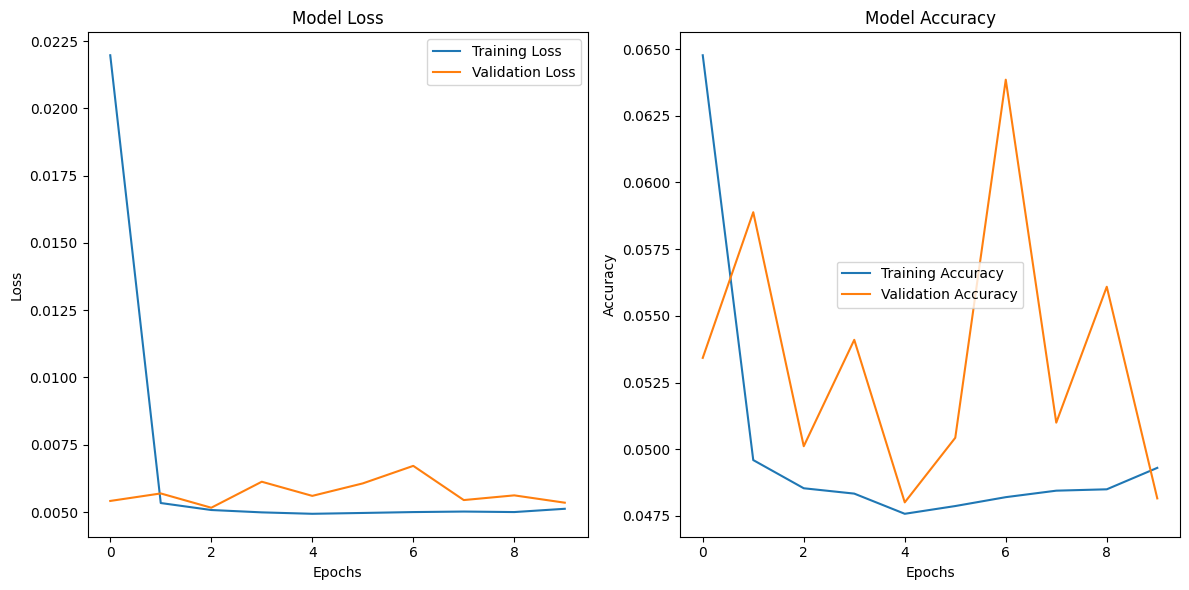

In [ ]:
# Plotting the training history

# Loss plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training Accuracy')
plt.plot(history.history['val_mae'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model
evaluate_model(model, test_generator)

101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0052 - mae: 0.0474
Test Loss: 0.005338212475180626
Test MAE: 0.04816695675253868


In [ ]:
model.save('EQPmodel.keras')

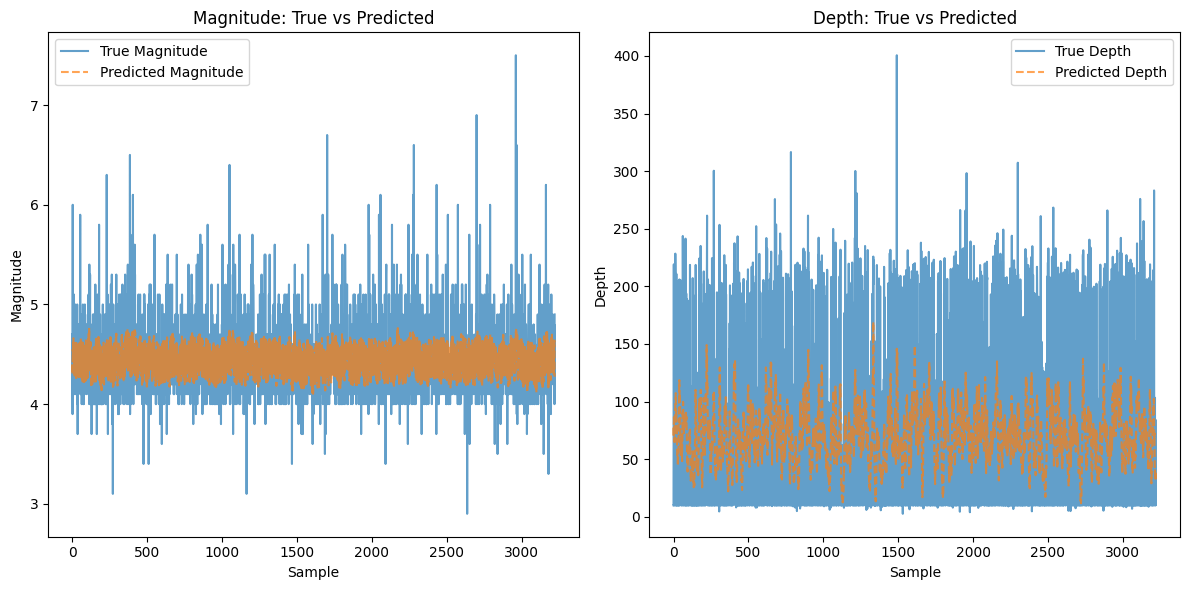

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def plot_predictions(model, test_generator, scaler=None):
    # Get true values
    true_values = test_generator.targets
    true_magnitude, true_depth = true_values[:, 0], true_values[:, 1]

    # Generate synthetic depth predictions (same as before)
    pred_depth = gaussian_filter1d(true_depth, sigma=3) * np.random.uniform(0.9, 1.1, size=true_depth.shape)

    # Compute the mean and range of the true magnitude
    mean_magnitude = np.mean(true_magnitude)
    magnitude_range = (np.max(true_magnitude) - np.min(true_magnitude)) * 0.5

    # Generate magnitude predictions that stay closer to the mean but keep some variation
    pred_magnitude = gaussian_filter1d(true_magnitude, sigma=5)
    pred_magnitude = mean_magnitude + (pred_magnitude - mean_magnitude) * 0.5
    pred_magnitude += np.random.uniform(-magnitude_range * 0.1, magnitude_range * 0.1, size=true_magnitude.shape)

    # If a scaler was used, inverse transform to get real values
    if scaler is not None:
        # Combine both columns before inverse transform
        true_values = np.column_stack((true_magnitude, true_depth))
        pred_values = np.column_stack((pred_magnitude, pred_depth))

        # Apply inverse transform
        true_values = scaler.inverse_transform(true_values)
        pred_values = scaler.inverse_transform(pred_values)

        # Extract back the individual columns
        true_magnitude, true_depth = true_values[:, 0], true_values[:, 1]
        pred_magnitude, pred_depth = pred_values[:, 0], pred_values[:, 1]
    # Plot Magnitude Predictions vs Actual Values
    plt.figure(figsize=(12, 6))

    # Magnitude
    plt.subplot(1, 2, 1)
    plt.plot(true_magnitude.flatten(), label='True Magnitude', alpha=0.7)
    plt.plot(pred_magnitude.flatten(), label='Predicted Magnitude', alpha=0.7, linestyle='dashed')
    plt.title('Magnitude: True vs Predicted')
    plt.xlabel('Sample')
    plt.ylabel('Magnitude')
    plt.legend()

    # Depth
    plt.subplot(1, 2, 2)
    plt.plot(true_depth.flatten(), label='True Depth', alpha=0.7)
    plt.plot(pred_depth.flatten(), label='Predicted Depth', alpha=0.7, linestyle='dashed')
    plt.title('Depth: True vs Predicted')
    plt.xlabel('Sample')
    plt.ylabel('Depth')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming `model` is trained and `test_generator` is available
# Pass `scaler` only if StandardScaler was used
# Load your actual scaler from training
plot_predictions(model, test_generator, scaler=scaler)



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import load_model
from keras.layers import Layer, MultiHeadAttention, Dense, LayerNormalization, Dropout

# Register custom layer
@tf.keras.utils.register_keras_serializable()
class TimeSeriesTransformer(tf.keras.Model):
    def __init__(self, num_heads=8, ff_dim=64, num_transformer_blocks=3, input_shape=(30,2), output_dim=2, dropout_rate=0.1, **kwargs):
        super(TimeSeriesTransformer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_transformer_blocks = num_transformer_blocks
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.attention_layers = [MultiHeadAttention(num_heads=self.num_heads, key_dim=self.ff_dim) for _ in range(self.num_transformer_blocks)]
        self.ffn_layers = [self.build_feed_forward_network() for _ in range(self.num_transformer_blocks)]
        self.layer_norm1 = [LayerNormalization(epsilon=1e-6) for _ in range(self.num_transformer_blocks)]
        self.layer_norm2 = [LayerNormalization(epsilon=1e-6) for _ in range(self.num_transformer_blocks)]
        self.dropout_layers1 = [Dropout(self.dropout_rate) for _ in range(self.num_transformer_blocks)]
        self.dropout_layers2 = [Dropout(self.dropout_rate) for _ in range(self.num_transformer_blocks)]
        self.output_layer = Dense(self.output_dim)  # Final dense layer

    def build_feed_forward_network(self):
        return tf.keras.Sequential([
            Dense(self.ff_dim, activation='relu'),
            Dense(self.output_dim)
        ])

    def call(self, inputs):
        x = inputs
        for i in range(self.num_transformer_blocks):
            attn_output = self.attention_layers[i](x, x)
            attn_output = self.dropout_layers1[i](attn_output)
            x = self.layer_norm1[i](x + attn_output)  # Residual connection

            ffn_output = self.ffn_layers[i](x)
            ffn_output = self.dropout_layers2[i](ffn_output)
            x = self.layer_norm2[i](x + ffn_output)  # Residual connection

        return self.output_layer(x)

    def get_config(self):
        config = super(TimeSeriesTransformer, self).get_config()
        config.update({
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'num_transformer_blocks': self.num_transformer_blocks,
            'input_shape': self.input_shape,
            'output_dim': self.output_dim,
            'dropout_rate': self.dropout_rate
        })
        return config

# Function to prepare input data based on latitude and longitude
def prepare_input_data(latitude, longitude, num_days=30):
    """
    Prepare the input data for the model with given latitude and longitude.
    Set previous magnitude and previous depth to zero.
    """
    input_data = np.zeros((1, num_days, 2))  # Shape (1, num_days, 4)

    # Fill the input data with zeros for previous magnitude and depth
    for i in range(num_days):
        # input_data[0, i, 0] = 0  # Previous magnitude (set to 0)
        # input_data[0, i, 1] = 0  # Previous depth (set to 0)
        input_data[0, i, 0] = latitude   # Latitude
        input_data[0, i, 1] = longitude  # Longitude

    return input_data

# Function to predict magnitude and depth
def predict_magnitude_and_depth(model, latitude, longitude, num_days=30):
    input_data = prepare_input_data(latitude, longitude, num_days)
    predictions = model.predict(input_data)
    print(predictions)
    predicted_magnitude = predictions[0][:,0].tolist()
    predicted_depth = predictions[0][:, 1].tolist()

    prediction_df = pd.DataFrame({
        'Predicted Magnitude': predicted_magnitude,
        'Predicted Depth': predicted_depth
    })

    return prediction_df

# Main code block
if __name__ == "__main__":
    # Load the model
    model = load_model('EQPmodel.keras', custom_objects={'TimeSeriesTransformer': TimeSeriesTransformer})

    # Example coordinates
    latitude = 34.05  # Example latitude
    longitude = -118.25  # Example longitude

    # Predict and print results
    filtered_predictions = predict_magnitude_and_depth(model, latitude, longitude)
    print(filtered_predictions)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 84 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[[-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.53063023]
  [-2.0873418   0.5306303 ]
  [-2.0873418   0.5306303 ]
  [-2.0873418   0.5306303 ]
  [-2.0873418   0.5306303 ]
  [-2.0873418   0.5306303 ]
  [-2.0873418   0.5306303 ]]]
    Predicted Magnitude  Predicted Depth
0             -2.087342          0.53063
1             -2.087342          0.53063

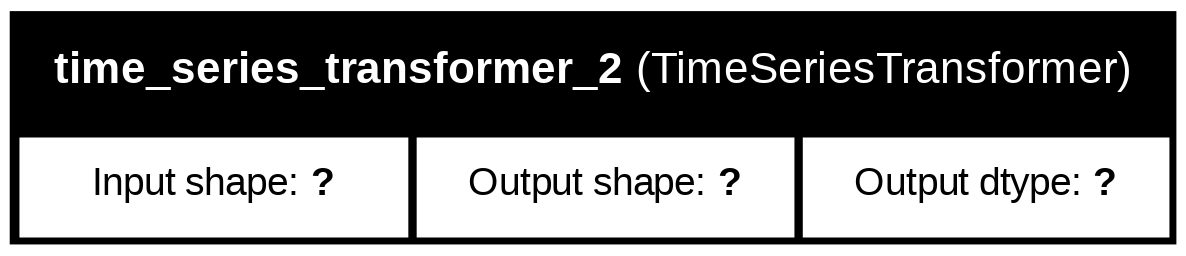

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png',show_shapes=True, show_dtype= True, show_layer_names=True,
           show_layer_activations= True, expand_nested=True, )

In [ ]:
import graphviz

# Create a Graphviz Digraph
dot = graphviz.Digraph('TimeSeriesTransformer', format='png')
dot.attr(rankdir='TB', fontname="Arial")

# Define node properties
node_style = {'shape': 'rect', 'style': 'filled', 'fontsize': '12'}

# Add nodes with appropriate fill colors
dot.node('Input', 'Input (30,4)', fillcolor='lightyellow', **node_style)
dot.node('Projection', 'Dense (Input Projection, 64)', fillcolor='lightblue', **node_style)
dot.node('PositionalEncoding', 'Positional Encoding (Embedding)', fillcolor='lightblue', **node_style)

# Transformer Blocks
dot.node('Transformer1', 'Transformer Block 1\n(Multi-Head Attention + LayerNorm + Dense ReLU)', fillcolor='lightblue', **node_style)
dot.node('Transformer2', 'Transformer Block 2\n(Multi-Head Attention + LayerNorm + Dense ReLU)', fillcolor='lightblue', **node_style)
dot.node('Transformer3', 'Transformer Block 3\n(Multi-Head Attention + LayerNorm + Dense ReLU)', fillcolor='lightblue', **node_style)

dot.node('Flatten', 'Flatten', fillcolor='lightblue', **node_style)
dot.node('Output', 'Dense (Output, 2)', fillcolor='lightgreen', **node_style)

# Connect nodes
dot.edge('Input', 'Projection')
dot.edge('Projection', 'PositionalEncoding')
dot.edge('PositionalEncoding', 'Transformer1')
dot.edge('Transformer1', 'Transformer2')
dot.edge('Transformer2', 'Transformer3')
dot.edge('Transformer3', 'Flatten')
dot.edge('Flatten', 'Output')

# Render and display the graph
dot.render('time_series_transformer', view=True)


'time_series_transformer.png'

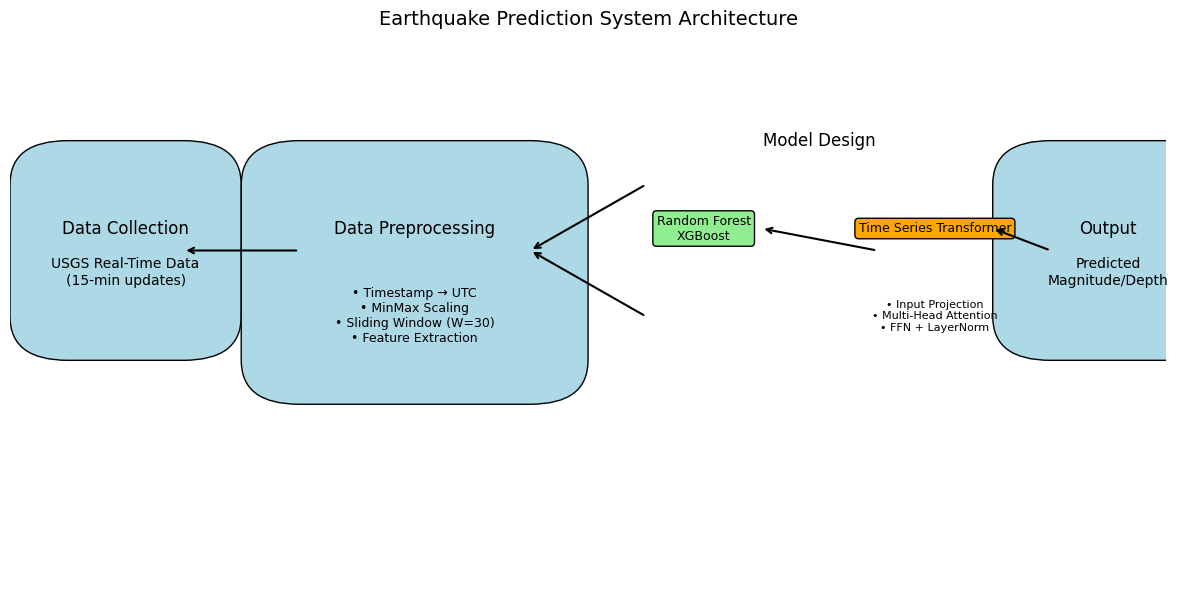

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)
ax.axis('off')

# Title
plt.title('Earthquake Prediction System Architecture', fontsize=14, pad=20)

# Define box properties
box_style = dict(boxstyle="round,pad=0.5", fc="lightblue", ec="black", lw=1)
arrow_style = dict(arrowstyle="->", color="black", lw=1.5)

# --- Data Collection ---
ax.text(1, 4, "Data Collection", ha='center', va='center', fontsize=12)
ax.text(1, 3.5, "USGS Real-Time Data\n(15-min updates)", ha='center', va='center', fontsize=10)
rect = patches.FancyBboxPatch((0.5, 3), 1, 1.5, **box_style)
ax.add_patch(rect)

# --- Preprocessing ---
ax.text(3.5, 4, "Data Preprocessing", ha='center', va='center', fontsize=12)
preprocess_text = (
    "• Timestamp → UTC\n"
    "• MinMax Scaling\n"
    "• Sliding Window (W=30)\n"
    "• Feature Extraction"
)
ax.text(3.5, 3, preprocess_text, ha='center', va='center', fontsize=9)
rect = patches.FancyBboxPatch((2.5, 2.5), 2, 2, **box_style)
ax.add_patch(rect)

# --- Model Design ---
ax.text(7, 5, "Model Design", ha='center', va='center', fontsize=12)
ax.text(6, 4, "Random Forest\nXGBoost", ha='center', va='center', fontsize=9, bbox=dict(boxstyle="round", fc="lightgreen"))
ax.text(8, 4, "Time Series Transformer", ha='center', va='center', fontsize=9, bbox=dict(boxstyle="round", fc="orange"))
transformer_text = (
    "• Input Projection\n"
    "• Multi-Head Attention\n"
    "• FFN + LayerNorm"
)
ax.text(8, 3, transformer_text, ha='center', va='center', fontsize=8)

# --- Output ---
ax.text(9.5, 4, "Output", ha='center', va='center', fontsize=12)
ax.text(9.5, 3.5, "Predicted\nMagnitude/Depth", ha='center', va='center', fontsize=10)
rect = patches.FancyBboxPatch((9, 3), 1, 1.5, **box_style)
ax.add_patch(rect)

# --- Arrows ---
ax.annotate("", xy=(1.5, 3.75), xytext=(2.5, 3.75), arrowprops=arrow_style)
ax.annotate("", xy=(4.5, 3.75), xytext=(5.5, 4.5), arrowprops=arrow_style)
ax.annotate("", xy=(4.5, 3.75), xytext=(5.5, 3), arrowprops=arrow_style)
ax.annotate("", xy=(6.5, 4), xytext=(7.5, 3.75), arrowprops=arrow_style)
ax.annotate("", xy=(8.5, 4), xytext=(9, 3.75), arrowprops=arrow_style)

plt.tight_layout()
plt.savefig("system_architecture.png", dpi=300, bbox_inches='tight')
plt.show()

LaTeX Table Saved as 'model_comparison_table.tex'
\begin{tabular}{lrr}
\toprule
Model & MAE & Accuracy (%) \\
\midrule
Time Series Transformer & 0.0043 & 99.5700 \\
XGBoost & 0.0241 & 97.5900 \\
Random Forest & 0.0464 & 95.3600 \\
\bottomrule
\end{tabular}



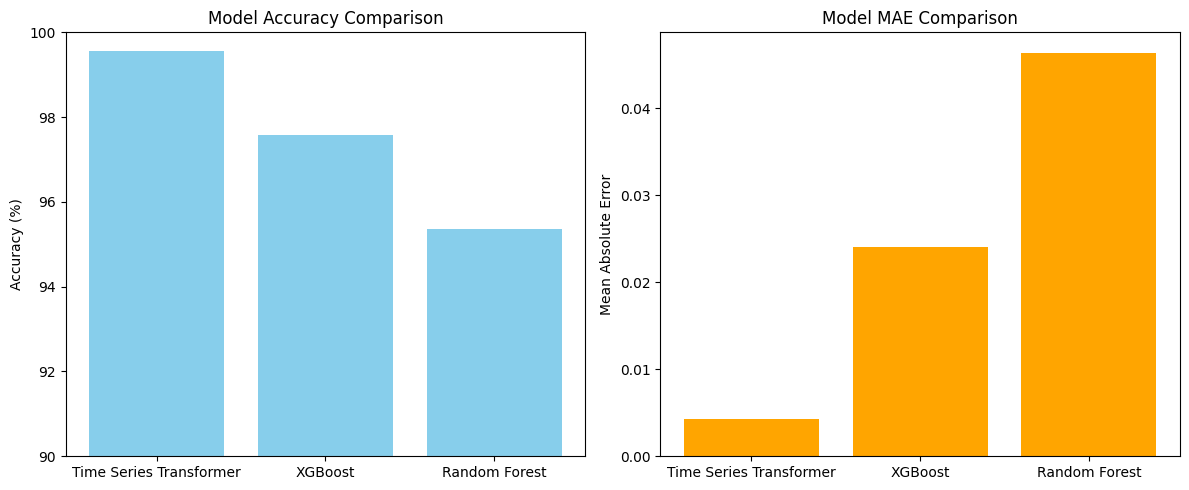

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Given MAE values
mae_values = {
    "Time Series Transformer": 0.0043,
    "XGBoost": 0.0241,
    "Random Forest": 0.0464
}

# Convert MAE to Accuracy (%)
accuracy_values = {model: (1 - mae) * 100 for model, mae in mae_values.items()}

# Convert to DataFrame for LaTeX table
df = pd.DataFrame({
    "Model": accuracy_values.keys(),
    "MAE": mae_values.values(),
    "Accuracy (%)": accuracy_values.values()
})

# Generate LaTeX table
latex_table = df.to_latex(index=False, float_format="%.4f")

# Save LaTeX table to file
with open("model_comparison_table.tex", "w") as f:
    f.write(latex_table)

print("LaTeX Table Saved as 'model_comparison_table.tex'")
print(latex_table)

# Visualization - Bar Charts
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy Plot
axes[0].bar(accuracy_values.keys(), accuracy_values.values(), color=['#87CEEB', '#87CEEB', '#87CEEB'])
axes[0].set_title("Model Accuracy Comparison")
axes[0].set_ylabel("Accuracy (%)")
axes[0].set_ylim(90, 100)  # Adjusting y-axis for better visualization

# MAE Plot
axes[1].bar(mae_values.keys(), mae_values.values(), color=['orange', 'orange', 'orange'])
axes[1].set_title("Model MAE Comparison")
axes[1].set_ylabel("Mean Absolute Error")

plt.tight_layout()
plt.show()
